In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

set_name = 'DataSet01_950Hz_snap=5'
# Training Data
X_train = np.loadtxt( './data/' + set_name + '/SBCEx16_training_input.txt')
Y_train = np.loadtxt( './data/'+ set_name + '/training_labels.txt')
Range_train = np.loadtxt( './data/'+ set_name  + '/Mapping_range_labels.txt')

# Test Data
X_test = np.loadtxt( './data/'+ set_name + '/SBCEx16_test_input.txt')
Y_test = np.loadtxt( './data/'+ set_name + '/test_Ranges.txt')

In [108]:
Y_train2 = np.loadtxt( './data/'+ set_name + '/training_Ranges.txt')

In [109]:
import math

##### MAPE function

In [110]:
def MAPE(pred, y):
    # the pred here should be Z_out
    # the y should be y_test
    n = len(y)
    return sum(np.abs(pred - y) / y) / n

### feature selection

In [111]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [112]:
clf = ExtraTreesClassifier()
clf = clf.fit(X_train, Y_train)
model = SelectFromModel(clf, prefit=True)

In [113]:
X_train2 = model.transform(X_train)
X_test2 = model.transform(X_test)

In [114]:
X_train2.shape

(890, 132)

### FNN

In [115]:
import tensorflow as tf

##### data preprocessing - use the range as y

In [116]:
y_train = np.matrix(Y_train2).T

In [117]:
print y_train.shape

(890, 1)


In [118]:
def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(weights)

In [119]:
def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
    """
    h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

#### Parameters for the model

In [120]:
n_in = X_train2.shape[1]
n_h1 = 512
n_cls = y_train.shape[1]

x = tf.placeholder(tf.float32, [None, n_in])
y = tf.placeholder(tf.float32, [None, n_cls])

In [121]:
def nn_model1(data, beta):
    W1 = init_weights((n_in, n_h1))
    b1 = tf.Variable(tf.zeros([n_h1]))

    Wout = init_weights((n_h1, n_cls))
    bout = tf.Variable(tf.zeros([n_cls]))
    
    l1 = tf.matmul(data, W1) + b1
    l1 = tf.nn.relu(l1)
    
    pred = tf.matmul(l1, Wout) + bout
    
    reg = beta*tf.nn.l2_loss(W1) + \
        beta*tf.nn.l2_loss(b1) + \
        beta*tf.nn.l2_loss(Wout) + \
        beta*tf.nn.l2_loss(bout)
    return pred, reg

#### Parameters for the Training

In [126]:
batch_size = 200
n_eps = 1000
disp_step = 10
learning_rate = 0.02
beta = 0.001

In [127]:
def train_nn1(data):
    pred, reg = nn_model1(data, beta)
    #cost = -tf.reduce_sum(y*tf.log(tf.clip_by_value(pred,1e-11,1.0)))
    cost = tf.reduce_sum(tf.pow(pred - y, 2) + reg)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    epochs = n_eps
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        #prev_loss = None
        
        for epoch in range(epochs):
            avg_cost = 0
            total_batch = int(X_train2.shape[0] / batch_size)
            
            # Training
            for i in range(total_batch):
                xb = X_train2[i * batch_size : (i + 1) * batch_size]
                yb = y_train[i * batch_size : (i + 1) * batch_size]
                _, c = sess.run([optimizer, cost], feed_dict = {x: xb, y: yb})
                avg_cost += c / total_batch
            
            if (epoch+1) % disp_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
            if math.isnan(avg_cost):
                break
            #prev_loss = loss
        print 'training finished!'
        predictions = sess.run(pred, feed_dict = {x: X_test2})
            
        
        print("accuarcy(train) =",sess.run(accuracy, feed_dict={x:X_train2, y: y_train}))
    return predictions
    
        #correct = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
        #accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        #print(sess.run(accuracy, feed_dict = \
        #               {x: mnist.test.images, y: mnist.test.labels}))

In [128]:
pred1 = train_nn1(x)

('Epoch:', '0010', 'cost=', '124438187.750000000')
('Epoch:', '0020', 'cost=', '53204024.000000000')
('Epoch:', '0030', 'cost=', '43385274.000000000')
('Epoch:', '0040', 'cost=', '38845464.500000000')
('Epoch:', '0050', 'cost=', '35036922.000000000')
('Epoch:', '0060', 'cost=', '31394173.000000000')
('Epoch:', '0070', 'cost=', '27896006.500000000')
('Epoch:', '0080', 'cost=', '24650489.500000000')
('Epoch:', '0090', 'cost=', '21689470.750000000')
('Epoch:', '0100', 'cost=', '19019327.500000000')
('Epoch:', '0110', 'cost=', '16636991.000000000')
('Epoch:', '0120', 'cost=', '14556614.250000000')
('Epoch:', '0130', 'cost=', '12766555.750000000')
('Epoch:', '0140', 'cost=', '11222684.250000000')
('Epoch:', '0150', 'cost=', '9887831.375000000')
('Epoch:', '0160', 'cost=', '8723513.750000000')
('Epoch:', '0170', 'cost=', '7702446.750000000')
('Epoch:', '0180', 'cost=', '6818646.625000000')
('Epoch:', '0190', 'cost=', '6053189.562500000')
('Epoch:', '0200', 'cost=', '5384926.187500000')
('Epo

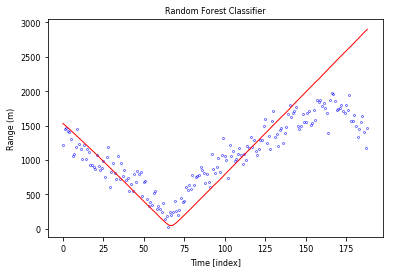

0.426328383553


In [20]:
Z_out = pred1

plt.plot(Z_out,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)

plt.xlabel('Time [index]',fontsize=8)
plt.ylabel('Range (m)',fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.title('Random Forest Classifier',fontsize=8)

plt.show()
print MAPE(np.array(Z_out[:, 0]), Y_test)

In [21]:
Z_out_10 = Z_out

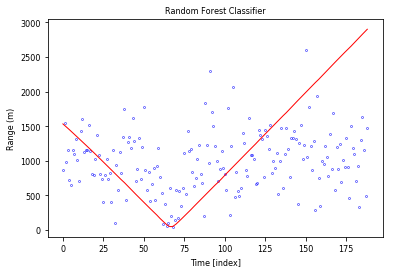

0.857839364081


In [129]:
Z_out = pred1

plt.plot(Z_out,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)

plt.xlabel('Time [index]',fontsize=8)
plt.ylabel('Range (m)',fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.title('Random Forest Classifier',fontsize=8)

plt.show()
print MAPE(np.array(Z_out[:, 0]), Y_test)

In [130]:
Z_out_950 = Z_out

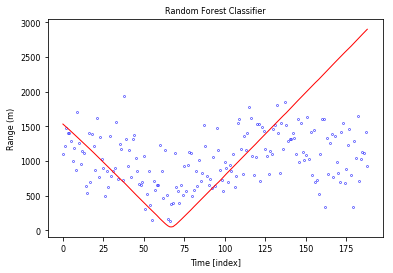

0.91521912891


In [106]:
Z_out = pred1

plt.plot(Z_out,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)

plt.xlabel('Time [index]',fontsize=8)
plt.ylabel('Range (m)',fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.title('Random Forest Classifier',fontsize=8)

plt.show()
print MAPE(np.array(Z_out[:, 0]), Y_test)

In [63]:
Z_out_550 = Z_out

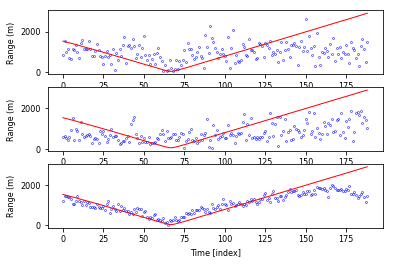

In [131]:
plt.subplot(311)
plt.plot(Z_out_950,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)

plt.xlabel('Time [index]',fontsize=8)
plt.ylabel('Range (m)',fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.subplot(312)
plt.plot(Z_out_550,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)

plt.xlabel('Time [index]',fontsize=8)
plt.ylabel('Range (m)',fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.subplot(313)
plt.plot(Z_out_10,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)

plt.xlabel('Time [index]',fontsize=8)
plt.ylabel('Range (m)',fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.show()